# EXPLORING THE MIMIC-III DATABASE
Note: this dataset is open-source, but restricted access. You must request access via https://mimic.physionet.org/gettingstarted/access/. I downloaded the dataset onto my personal computer and ran the analyses locally. Given HIPAA and privacy considerations, I will only show summary plots from data in the database (no patient-specific information will be displayed.

I'm first loading in the PATIENTS, ADMISSIONS, ICUSTAYS, and PRESCRIPTIONS databases, then performing some simple conversions and calculations, and then merging the datasets.

Ultimately, I wanted to look at the relationship between a number of factors and the timing of transfer to the ICU relative to hospital admission.

In [1]:
import pandas as pd

In [2]:
#1. Load patients
# import patient info
data_dir = 'data/physionet.org/files/mimiciii/1.4/'
patient_file = 'PATIENTS.csv'
df_patients = pd.read_csv(data_dir + patient_file)

In [3]:
df_patients=df_patients.drop(['ROW_ID','DOD_HOSP','DOD_SSN'],axis=1)

In [4]:
# convert date strings to datetime
df_patients.DOB = pd.to_datetime(df_patients.DOB,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_patients.DOD = pd.to_datetime(df_patients.DOD,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [5]:
# import admissions info
admissions_file = 'ADMISSIONS.csv'
df_admissions = pd.read_csv(data_dir + admissions_file)
df_admissions = df_admissions.drop(['ROW_ID','RELIGION','LANGUAGE','MARITAL_STATUS','ETHNICITY'],axis=1)

In [6]:
# convert time strings to datetime
df_admissions.ADMITTIME = pd.to_datetime(df_admissions.ADMITTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admissions.DISCHTIME = pd.to_datetime(df_admissions.DISCHTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admissions.EDREGTIME = pd.to_datetime(df_admissions.EDREGTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admissions.EDOUTTIME = pd.to_datetime(df_admissions.EDOUTTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [7]:
# calculate length of hospital stay
df_admissions['HOSPITAL_DAYS'] = (df_admissions['DISCHTIME'] - df_admissions['ADMITTIME']).dt.total_seconds()/(24*60*60)
# negative admit days = dead on arrival, remove
doa_idx = df_admissions[df_admissions['HOSPITAL_DAYS']<0].index
df_admissions = df_admissions.drop(doa_idx,axis=0)

In [8]:
# merge patient and admissions df
df_patient_admit = df_patients.merge(df_admissions,how='inner',left_on=['SUBJECT_ID'],right_on=['SUBJECT_ID'])

In [9]:
# calculate age at admit
df_patient_admit['ADMIT_AGE'] = df_patient_admit['ADMITTIME'].dt.year - df_patient_admit['DOB'].dt.year

In [10]:
# 2. Remove patients <age
# not necessary, but wanted to limit analysis to non-pediatric issues
age = 10
child_idx = df_patient_admit[df_patient_admit['ADMIT_AGE']<age].index
child_patients = df_patient_admit.iloc[child_idx]['SUBJECT_ID'].unique()
df_patient_admit = df_patient_admit.drop(child_idx, axis=0)

In [11]:
# 3. Load icustays
# import icu stays info
icustays_file = 'ICUSTAYS.csv'
df_icustays = pd.read_csv(data_dir + icustays_file)

child_idx = df_icustays[df_icustays['SUBJECT_ID'].isin(child_patients)].index
df_icustays = df_icustays.drop(child_idx,axis=0)

df_icustays = df_icustays.drop(['ROW_ID'],axis=1)
df_icustays.INTIME = pd.to_datetime(df_icustays.INTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_icustays.OUTTIME = pd.to_datetime(df_icustays.OUTTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [12]:
#join admissions and icu stays
df_admit_icu = df_admissions.merge(df_icustays,how='inner',left_on=['SUBJECT_ID','HADM_ID'],right_on=['SUBJECT_ID','HADM_ID'])

In [13]:
# removing columns not used for further analyses
cols_to_rmv = list(set(df_admit_icu.columns) & set(df_patient_admit))
# keep SUBJECT_ID and HADM_ID for merge
sbj_idx = cols_to_rmv.index('SUBJECT_ID')
cols_to_rmv.pop(sbj_idx)
h_idx = cols_to_rmv.index('HADM_ID')
cols_to_rmv.pop(h_idx)

df_admit_icu = df_admit_icu.drop(cols_to_rmv,axis=1)

In [14]:
df_patient_admit_icu = df_patient_admit.merge(df_admit_icu,how='inner',left_on=['SUBJECT_ID','HADM_ID'],right_on=['SUBJECT_ID','HADM_ID'])

In [15]:
# calculate days from hospital admission to icu admission
df_patient_admit_icu['DAYS_ADM_TO_ICU'] = (df_patient_admit_icu['INTIME'] - df_patient_admit_icu['ADMITTIME']).dt.total_seconds()/(24*60*60)

In [16]:
# 4. Load prescriptions
# import prescriptions info
prescrips_file = 'PRESCRIPTIONS.csv'
df_prescrips = pd.read_csv(data_dir + prescrips_file,low_memory=False)

df_prescrips = df_prescrips.drop(['ROW_ID','GSN','DRUG','DRUG_NAME_POE','DRUG_NAME_GENERIC','FORMULARY_DRUG_CD'],axis=1)
ndc_nan_idx = df_prescrips[df_prescrips['NDC'].isna()].index
df_prescrips=df_prescrips.drop(ndc_nan_idx,axis=0)

df_prescrips.STARTDATE = pd.to_datetime(df_prescrips.STARTDATE,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# using NDC code for drug identity rather than drug names since working with numerics is easier
df_prescrips['NDC'] = df_prescrips['NDC'].astype('int64')

In [17]:
child_idx = df_prescrips[df_prescrips['SUBJECT_ID'].isin(child_patients)].index
df_prescrips = df_prescrips.drop(child_idx,axis=0)

In [18]:
# merge datasets
# keep left merge here because we want to be flexible for including patients admitted to ICU w/o prescription info
df_patient_admit_icu_prescrip = df_patient_admit_icu.merge(df_prescrips,how='left',left_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],right_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

Now I want to calculate the time between a drug was prescribed (proxy for time a drug was taken) and transfer to the ICU, under the hypothesis that perhaps certain drugs (or combinations of drugs) are predictive of an imminent need for ICU care.

In [19]:
# calculate days from hospital admission to drug prescription
df_patient_admit_icu_prescrip['DAYS_ADM_TO_DRUG'] = (df_patient_admit_icu_prescrip['STARTDATE'] - df_patient_admit_icu_prescrip['ADMITTIME']).dt.total_seconds()/(24*60*60)

In [20]:
# calculate time of drug prescription relative to ICU stay (<0 means ICU stay comes before drug prescription)
df_patient_admit_icu_prescrip['DAYS_DRUG_BEFORE_ICU'] = df_patient_admit_icu_prescrip['DAYS_ADM_TO_ICU'] - df_patient_admit_icu_prescrip['DAYS_ADM_TO_DRUG']

In [21]:
# keep only rows where drugs were prescribed prior to ICU stay
df_patient_admit_icu_prescrip_drugsfirst = df_patient_admit_icu_prescrip[df_patient_admit_icu_prescrip['DAYS_DRUG_BEFORE_ICU']>0]

In [22]:
# for each subject, hospital admission, and associated icu stay: determine the number and list of drugs prescribed and mean times
from numpy import nansum, nanmean
prescrips_by_combo_before_icu = df_patient_admit_icu_prescrip_drugsfirst.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).agg({'NDC': ['count', list],'DAYS_ADM_TO_ICU': [nanmean],'DAYS_ADM_TO_DRUG': [nanmean],'DAYS_DRUG_BEFORE_ICU': [nanmean]})

Text(0.5, 1.0, 'Days from Admit to ICU')

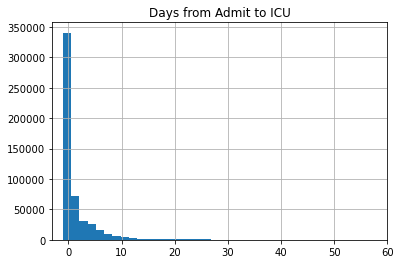

In [23]:
import matplotlib.pyplot as plt
df_patient_admit_icu_prescrip_drugsfirst['DAYS_ADM_TO_ICU'].hist(bins=100)
plt.xlim([-3, 60])
plt.title('Days from Admit to ICU')

This figure shows the distribution of days from admission to ICU stay. We can see that the distribution is heavily skewed right, and there are ~350K entries where the time from hospital admission to ICU stay is <=1 day, and perhaps ~100K entries where time from hospital admission to ICU stay is >1 day. I am looking to identify features that predict when times will be <1 day and/or what features discriminate between times <=1 day and times >1day.

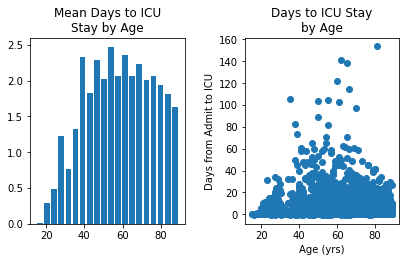

In [24]:
# look at the relationship between age and time between hospital admission and ICU stay

from scipy.stats import binned_statistic
from matplotlib.pyplot import bar

sbj_cnt_icu_ttl = df_patient_admit_icu_prescrip_drugsfirst.groupby(['SUBJECT_ID']).agg({'SUBJECT_ID' : ['count'], 'DAYS_ADM_TO_ICU' : [nanmean], 'ADMIT_AGE' : [nanmean]})

# drop patients 90+ with no real age information
noage_idx = sbj_cnt_icu_ttl[sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')]>=300].index
sbj_cnt_icu_ttl = sbj_cnt_icu_ttl.drop(noage_idx,axis=0)

# drop nan
sbj_cnt_icu_ttl.dropna(subset=[('ADMIT_AGE','nanmean')],inplace=True)

# find mean ICU days based on bins of ADMIT_AGE
bin_means, bin_edges, binnumber = binned_statistic(sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')],sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')],bins=20)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

figure, _ = plt.subplots(nrows=1, ncols=2)
ax = plt.subplot(1,2,1)
bar(bin_centers, bin_means,width=3)
plt.title('Mean Days to ICU\nStay by Age')

plt.subplot(1,2,2)
plt.plot(sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')],sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')],'o')
plt.title('Days to ICU Stay\nby Age')
plt.xlabel('Age (yrs)')
plt.ylabel('Days from Admit to ICU')
figure.tight_layout(pad=2.0)

This figure shows the relationship between age at time of hospital admission and the days between hospital admission and ICU stay. From the plots, there appears to be a slight relationship between age and time to ICU stay, with younger patients more likely to require faster transfers to the ICU.

In [25]:
sbj_cnt_icu_ttl.corr()

,,SUBJECT_ID,DAYS_ADM_TO_ICU,ADMIT_AGE
,,count,nanmean,nanmean
SUBJECT_ID,count,1.000000,0.007922,0.036440
DAYS_ADM_TO_ICU,nanmean,0.007922,1.000000,0.031614
ADMIT_AGE,nanmean,0.036440,0.031614,1.000000


In [26]:
from scipy.stats import pearsonr
corr_stats = pearsonr(y=sbj_cnt_icu_ttl[('DAYS_ADM_TO_ICU','nanmean')], x=sbj_cnt_icu_ttl[('ADMIT_AGE','nanmean')])
corr_stats

(0.031614387526150686, 0.00013518717080659385)

Above, I calculate the correlation between age and days to ICU transfer. As we can see, there is a small correlation between admit age and ICU transfer. Given the size of the dataset, this is  significant (p<0.00014).

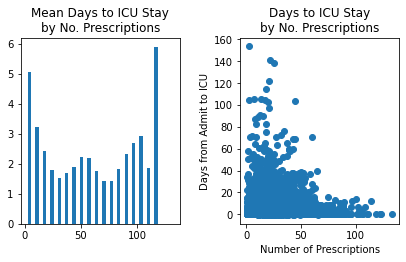

In [27]:
# now let's look at the relationship between number of prescriptions for a patient and days to ICU stay

# binned days to ICU stay by number of prescriptions
bin_means, bin_edges, binnumber = binned_statistic(prescrips_by_combo_before_icu[('NDC','count')],prescrips_by_combo_before_icu[('DAYS_ADM_TO_ICU','nanmean')],bins=20)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

figure, _ = plt.subplots(nrows=1, ncols=2)
ax = plt.subplot(1,2,1)
bar(bin_centers, bin_means,width=3)
plt.title('Mean Days to ICU Stay\nby No. Prescriptions')

plt.subplot(1,2,2)
plt.plot(prescrips_by_combo_before_icu[('NDC','count')],prescrips_by_combo_before_icu[('DAYS_ADM_TO_ICU','nanmean')],'o')
plt.title('Days to ICU Stay\nby No. Prescriptions')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Days from Admit to ICU')
figure.tight_layout(pad=2.0)

This figure shows the relationship between number of prescriptions and time from hospital admission to ICU stay. It appears there is a weak relationship, with more prescriptions being associated with a slightly shorter time to ICU transfer.

In [28]:
prescrips_by_combo_before_icu.corr()

,,NDC,DAYS_ADM_TO_ICU,DAYS_ADM_TO_DRUG,DAYS_DRUG_BEFORE_ICU
,,count,nanmean,nanmean,nanmean
NDC,count,1.000000,-0.068962,-0.072370,0.136658
DAYS_ADM_TO_ICU,nanmean,-0.068962,1.000000,0.999707,0.067207
DAYS_ADM_TO_DRUG,nanmean,-0.072370,0.999707,1.000000,0.043037
DAYS_DRUG_BEFORE_ICU,nanmean,0.136658,0.067207,0.043037,1.000000


In [29]:
pearsonr(y=prescrips_by_combo_before_icu[('DAYS_ADM_TO_ICU','nanmean')], x=prescrips_by_combo_before_icu[('NDC','count')])

(-0.06896232677555325, 7.638766402853302e-20)

In [30]:
pearsonr(y=prescrips_by_combo_before_icu[('DAYS_DRUG_BEFORE_ICU','nanmean')], x=prescrips_by_combo_before_icu[('NDC','count')])

(0.13665835402810433, 1.7633280693418123e-73)

This is confirmed with the small, negative correlation value of -0.07 (p<8e-20). (Unsurprisingly, there seems to be a positive correlation between number of drugs and days drugs were prescribed prior to ICU transfer [p<2e-73]. This may be related to the fact that more drugs can be prescribed during longer stays between hospital admission and ICU stay.)

In [31]:
# now let's look at the relationship between diagnosis and days to ICU stay
icu_by_diagnoses = df_patient_admit_icu_prescrip_drugsfirst.groupby(['DIAGNOSIS']).agg({'DIAGNOSIS': ['count'],'NDC': [nanmean],'DAYS_ADM_TO_ICU': [nanmean,'sem'],'DAYS_ADM_TO_DRUG': [nanmean],'DAYS_DRUG_BEFORE_ICU': [nanmean]})
# there are ~6000 unique diagnoses, so for visualization let's only look at the most common 30
icu_by_top_diagnoses = icu_by_diagnoses.sort_values(by=('DIAGNOSIS','count'),ascending=False).head(30)

([<matplotlib.axis.XTick at 0x7feb083cd3d0>,
 [Text(0, 0, 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA'),
  Text(0, 0, 'SEPSIS'),
  Text(0, 0, 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA'),
  Text(0, 0, 'ABDOMINAL PAIN'),
  Text(0, 0, 'S/P FALL'),
  Text(0, 0, 'DIABETIC KETOACIDOSIS'),
  Text(0, 0, 'HYPOTENSION'),
  Text(0, 0, 'CORONARY ARTERY DISEASE\\CATH'),
  Text(0, 0, 'BLUNT TRAUMA'),
  Text(0, 0, 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA')])

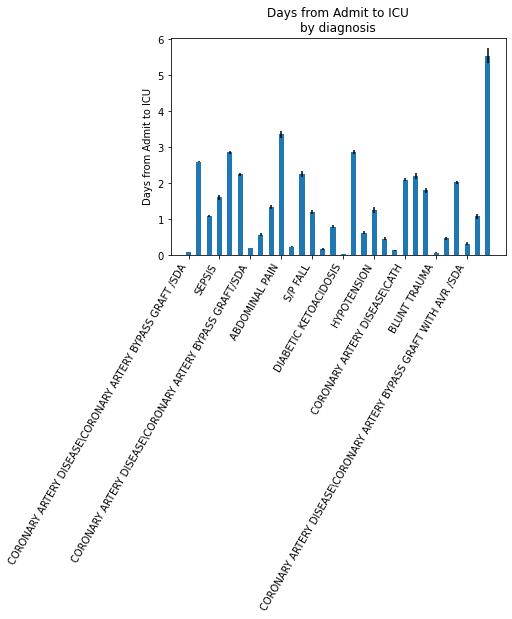

In [32]:
plt.bar(x=icu_by_top_diagnoses.index,
        height=icu_by_top_diagnoses[('DAYS_ADM_TO_ICU','nanmean')],width=0.5,
       yerr=icu_by_top_diagnoses[('DAYS_ADM_TO_ICU','sem')])
plt.title('Days from Admit to ICU\nby diagnosis')
plt.ylabel('Days from Admit to ICU')
xlabels = icu_by_top_diagnoses.index
plt.xticks(range(0,len(xlabels),3),xlabels[0::3],rotation=60,ha='right')

This figure plots a summary of mean days to ICU stay by diagnosis. It is clear that certain diagnoses (e.g., coronary artery disease, blunt trauma) typically require near-immediate ICU stay, whereas others do not. (NOTE: I realize some diagnoses in the plot are likely duplicated with slight differences in spacing, etc. I will need to fix this later on...)

In the future, I would like to look at a regression model using the top X diagnoses as categorical variables to get a more analytical assessment of this relationship.

In [33]:
# let's make a simplified binary classification of whether the ICU stay occurred within 24 hours of hospital admission
df_patient_admit_icu_prescrip_drugsfirst['SAMEDAY_ADM_TO_ICU'] = df_patient_admit_icu_prescrip_drugsfirst['DAYS_ADM_TO_ICU'].apply(lambda x: int(x<=1))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


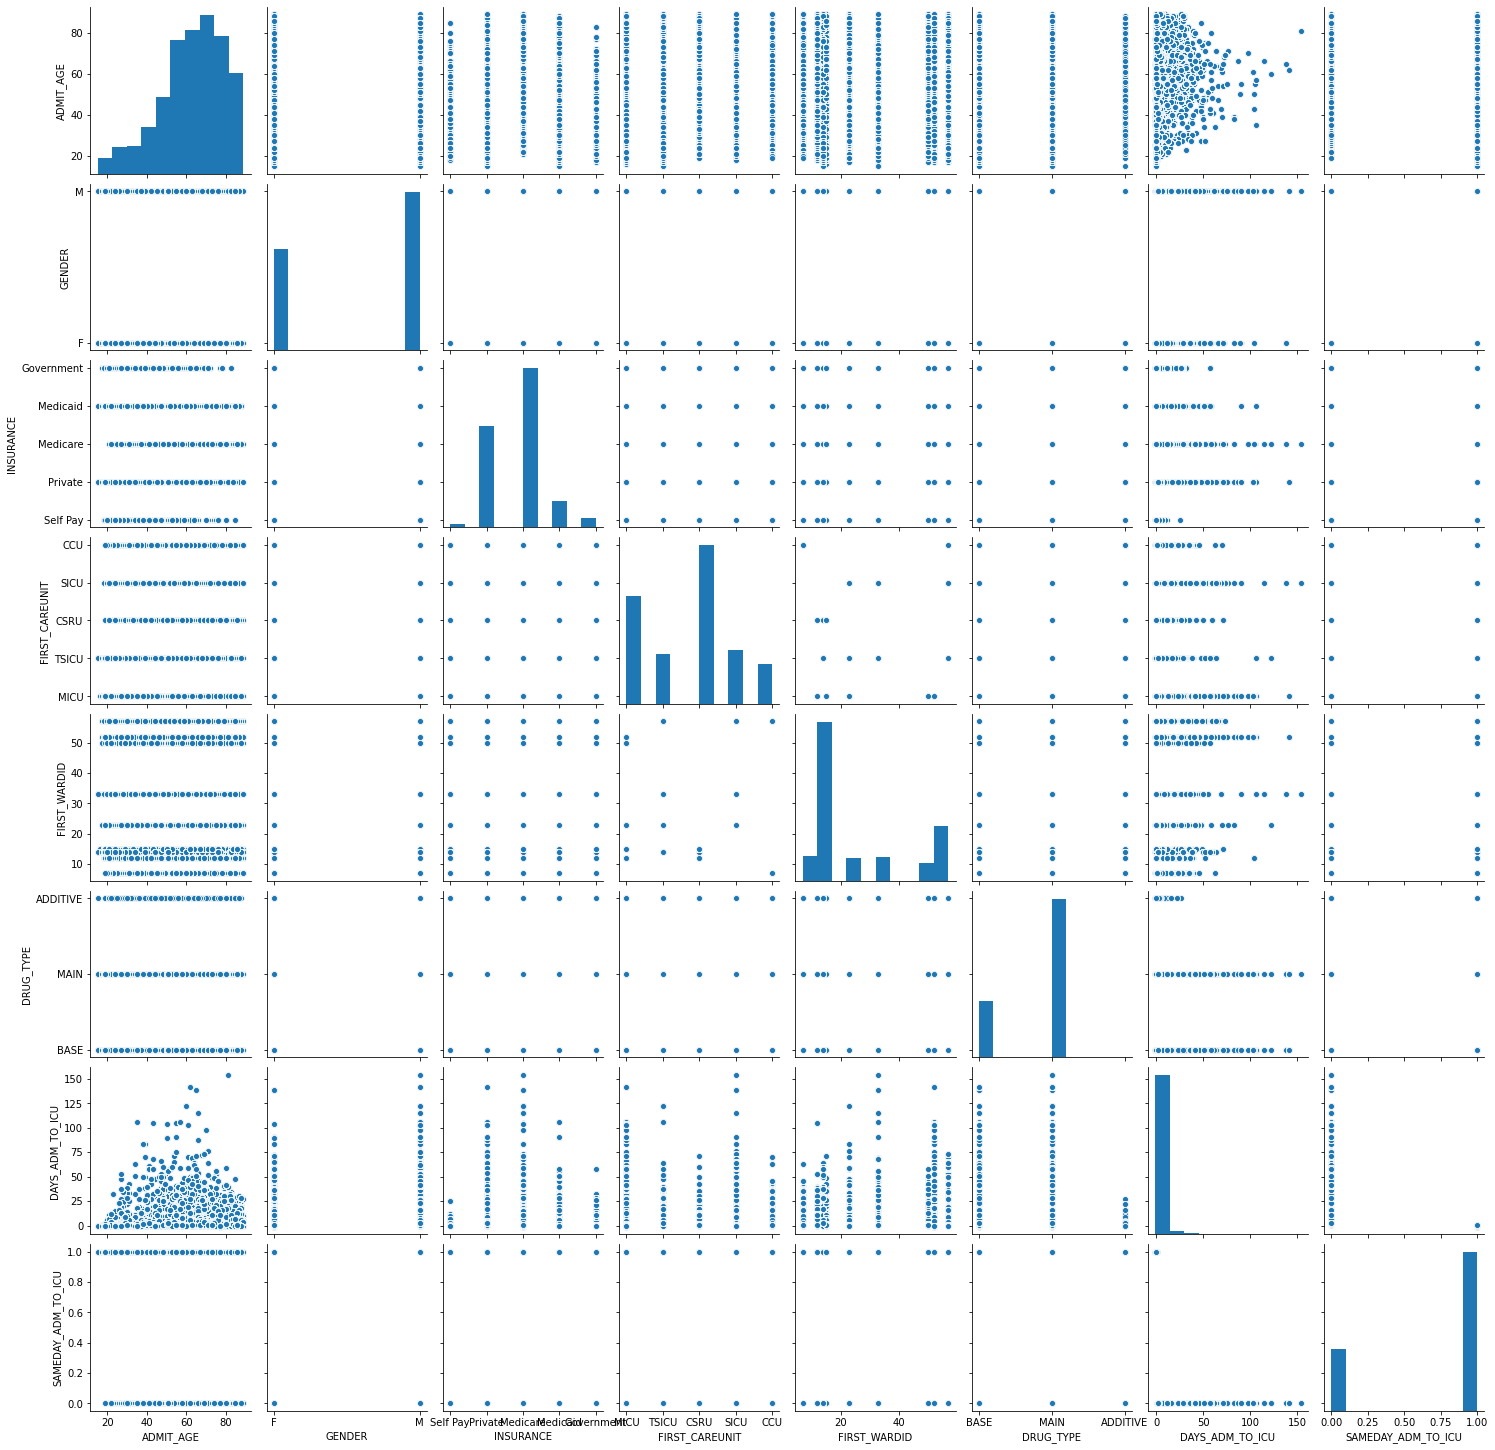

In [34]:
# let's now look at a bunch of other features and their relationship to DAYS_ADM_TO_ICU or SAMEDAY_ADM_TO_ICU
import seaborn as sns
df_toplot = df_patient_admit_icu_prescrip_drugsfirst[df_patient_admit_icu_prescrip_drugsfirst['ADMIT_AGE']<100]
variables = ['ADMIT_AGE','GENDER','INSURANCE','FIRST_CAREUNIT','FIRST_WARDID','DRUG_TYPE','DAYS_ADM_TO_ICU','SAMEDAY_ADM_TO_ICU']
sns.pairplot(df_toplot,vars = variables)
plt.show()

The above figure looks at a number of other features to see their relationship to either days to ICU stay or SAMEDAY_ADM_TO_ICU. From the plot, it appears that:
1. there is a weak correlation between age and time to ICU (as shown previously)
2. females are transferred faster to the ICU compared to males
3. self-insured patients have faster transfers compared to other types
4. there may be a weak relationship between DRUG_TYPE and DAYS_ADM_TO_ICU

The other things I would next like to look at are: vital signs, lab tests/results, and (ideally) a text analysis of chart events/notes and their relation to imminent (e.g., <1 day) ICU stays.

Lastly, I also want to develop a metric for risk of imminent ICU stay in and to identify what features increase/decrease that risk. Ideally, the program could take patient-specific info/features, compute a risk factor for imminent ICU stay, and (given their information) recommend treatments/features that might reduce that patient's risk for and ICU stay.

In [35]:
col_list = ['DOD','DEATHTIME']
df_patient_admit_icu_prescrip = df_patient_admit_icu_prescrip.drop(col_list,axis=1)

In [ ]:
 '''this section will have ~3000 iterations, and runs out of memory. moving to parallel processing and batch loading
 into another notebook'''
    
# load chart and lab events
# look for discrepancies in duplicates, merge data and keep lab events where discrepancies exist
chart_file = 'CHARTEVENTS.csv'

# want to count lines in CHARTEVENTS to make for loop below
row_count = 330712483 # from chart description

# chart file is 35GB, so need to load it in chunks and preprocess it by left merging with existing
skiprows = 0
nrows = 100000  # defualt
colnames = ['ROW_ID','SUBJECT_ID','HADM_ID','ICUSTAY_ID','ITEMID','CHARTTIME','STORETIME','CGID','VALUE','VALUENUM','VALUEUOM','WARNING','ERROR','RESULTSTATUS','STOPPED']
usecols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','ITEMID','CHARTTIME','VALUE','VALUENUM','VALUEUOM']
cnt=0
while skiprows<=row_count:
    print(cnt)
    if skiprows + nrows > row_count:
        nrows = row_count - skiprows
    else:
        nrows = 100000
    
    df = pd.read_csv(data_dir + chart_file,sep=',', header=0, names = colnames,skiprows=skiprows, nrows=nrows, usecols=usecols)
    # convert charttime to datetime
    df.CHARTTIME = pd.to_datetime(df.CHARTTIME,format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
    
    df = df.merge(df_patient_admit_icu_prescrip,how='inner',left_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],right_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])
    # calculate days from chart event to icu admission
    df['DAYS_CHRT_TO_ICU'] = (df['INTIME'] - df['CHARTTIME']).dt.total_seconds()/(24*60*60)

    # remove rows where chart event occurred after icu admission
    icu_evnt_idx = df[df['DAYS_CHRT_TO_ICU']<=0].index
    df = df.drop(icu_evnt_idx,axis=0)

    if n==0:
        df_ptnt_adm_icu_rx_chrt = df
    else:
        df_ptnt_adm_icu_rx_chrt = df_ptnt_adm_icu_rx_chrt.append(df)
    
    skiprows += nrows
    cnt += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
